# Bag of Visual Words (BoW) Classifier

*Marco Tallone*\
*Scientific and Data-Intensive Computing (SDIC) - UniTS*\
*Computer Vision and Pattern Recognition (CVPR) Exam Project*\
*2024/2025*

This notebboks presents an implementation of an image classifier based on the Bag of Visual Words (BoW) approach. More specifically, the overall objective of this project is to build and test a classifier for scene recognition. Throughout the notebook a few classiers are tested, mostly based on $k$-Nearest Neighbors ($k$-NN) and Support Vector Machines (SVM) with different strategies.\
The notebook is structured as follows:

1. **Imports**: general set-up and import of libraries, modules and utility functions
2. **Data Exploration**: prelimirary analysis of the dataset
3. **Feature Extraction**: extraction of features from the images
4. **Clustering**: clustering of the features to build a visual vocabulary
5. **Normalized Histogram Representation**: representation of the images as normalized histograms of visual words
6. **TF-IDF Representation**: representation of the images as TF-IDF weighted histograms of visual words
7. **K-Nearest Neighbors (k-NN) Classifier**: implementation and testing of a $k$-NN classifier
8. **Support Vector Machines (SVM) Classifiers**: implementation and testing of multiple SVM classifiers with different strategies
9. **Grid Descriptors Sampling**: testing the effect of sampling SIFT descriptors on a regular grid
10. **Spatial Pyramid Matching**: implementation of the Spatial Pyramid Matching approach to add spatial information to the BoW model

## Imports

First of all, we load all the necessary modules and utility functions that has been defined in the `utils.py` file to improve the readability of the notebook. All the functions are documented in the file and further information can be retrieved by calling the `help()` function on them.\
We also need to set the location of the dataset relative to the notebook in order to load the images and the labels.

In [1]:
# import modules and utility functions
from utils import *

# Constants
DATASET_DIR = "../datasets"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")

Imported libraries:
	- Numpy version: 1.26.4
	- OpenCV version: 4.10.0
	- SciKit-Learn version: 1.5.2

Imported functions:
	- load_images()
	- get_histogram()
	- get_tfidf()
	- get_pyramid_histogram()
	- pyramid_kernel()


## Data Exploration

The classifiers later implemented will be trained and tested on the $15$ scene dataset by *Lazebnik et al.*. The dataset is a collection $4485$ of images of $15$ different scene categories. This comes already separated in train and test sets.\
We can now load the images and the corresponding labels with the dedicated function.

In [2]:
# Load data
train_images, train_labels, classes = load_images(TRAIN_DIR)
test_images,  test_labels, 	_       = load_images(TEST_DIR)

# Data information
print(f"Number of classes: {len(classes)}")
print(f"Number of training images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Loading images:   0%|          | 0/15 [00:00<?, ?it/s]

Loading images:   0%|          | 0/15 [00:00<?, ?it/s]

Number of classes: 15
Number of training images: 1500
Number of test images: 2985


We can plot the number of images for each class both for the training and testing sets to check their distribution.

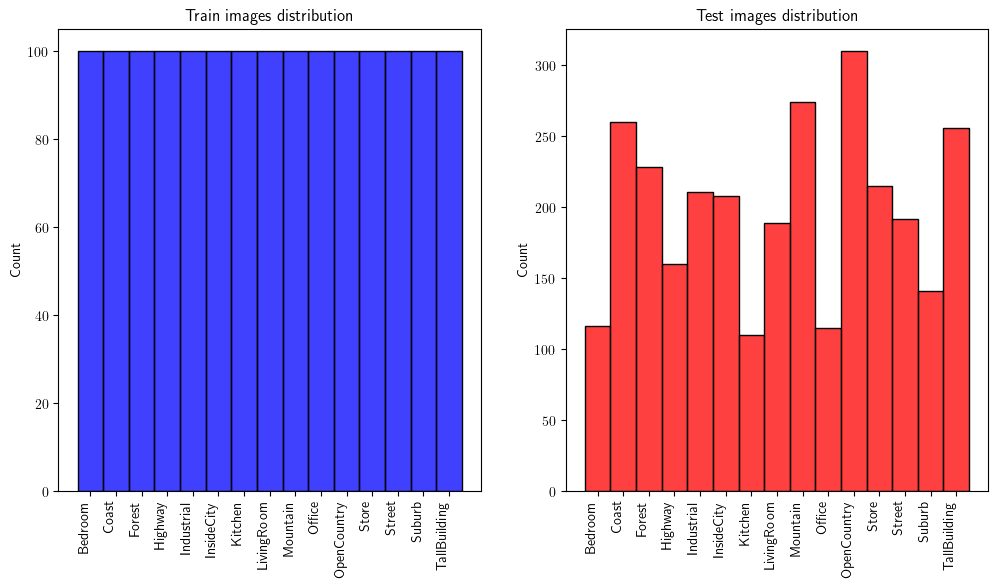

In [3]:
# Classes distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(train_labels, bins=len(classes), ax=ax[0], color="blue", binrange=[0, len(classes)], binwidth=1)
ax[0].set_title("Train images distribution")
ax[0].set_xticks([i + 0.5 for i in range(len(classes))])
ax[0].set_xticklabels(classes, rotation=90, ha='right')

sns.histplot(test_labels, bins=len(classes), ax=ax[1], color="red", binrange=[0, len(classes)], binwidth=1)
ax[1].set_title("Test images distribution")
ax[1].set_xticks([i + 0.5 for i in range(len(classes))])
ax[1].set_xticklabels(classes, rotation=90, ha='right')

plt.show()

As we can see we have a uniform distribution of $100$ images for each of the $15$ classes in the training set, while a total of $2985$ images non-uniformly distributed are available in the testing set.

We can also see that the images have different sizes and aspect ratios by looking at the following plots. We might keep this in mind as this will affect the total number of keypoints extracted from each image.

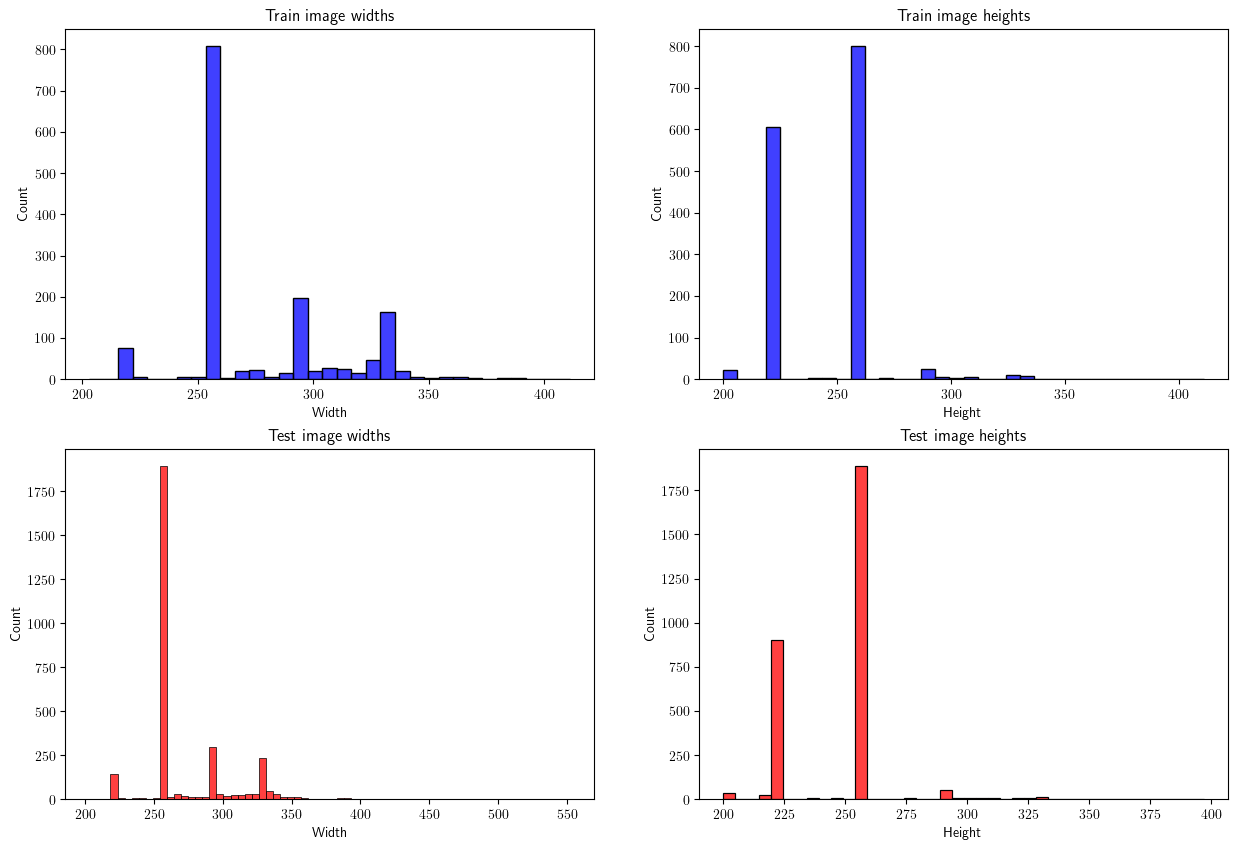

In [4]:
# Sizes of the images

# Measure image sizes
train_widths = [image.shape[1] for image in train_images]
train_heights = [image.shape[0] for image in train_images]
test_widths = [image.shape[1] for image in test_images]
test_heights = [image.shape[0] for image in test_images]

# Plot the image sizes
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(train_widths, ax=ax[0, 0], color="blue")
ax[0, 0].set_title("Train image widths")
ax[0, 0].set_xlabel("Width")
ax[0, 0].set_ylabel("Count")

sns.histplot(train_heights, ax=ax[0, 1], color="blue")
ax[0, 1].set_title("Train image heights")
ax[0, 1].set_xlabel("Height")
ax[0, 1].set_ylabel("Count")

sns.histplot(test_widths, ax=ax[1, 0], color="red")
ax[1, 0].set_title("Test image widths")
ax[1, 0].set_xlabel("Width")
ax[1, 0].set_ylabel("Count")

sns.histplot(test_heights, ax=ax[1, 1], color="red")
ax[1, 1].set_title("Test image heights")
ax[1, 1].set_xlabel("Height")
ax[1, 1].set_ylabel("Count")

plt.show()

## Feature Extraction

Before implementing any classifier, the first objective of this project is to build a visual vocabulary of visual words. In this context the visual vocabulary will actually be obtained from a set of measurable features extracted from the images, in particular from SIFT descriptors. Therefore, visual words will be $128$-dimensional vectors representing the SIFT descriptors (*more precisely the centroids resulting from the clustering of the SIFT descriptors as explained below*).\
Hence, we need to sample SIFT descriptors from the train set images and this can be done in two ways:

1. **SIFT Detector**: use the SIFT detector to extract keypoints and then compute the SIFT descriptors for each keypoint
2. **Grid Sampling**: sample SIFT descriptors on a regular grid over the image

We will focus on the first approach for the moment, but the second one will be later compared.

In [5]:
# Initialize SIFT detector and descriptor
FEATURES = 500
sift = cv2.SIFT_create(FEATURES)

# Compute descriptors from detected keypoints
descriptors = []
n_descriptors = []
for image in tqdm.tqdm(
    train_images, 
    desc="Computing descriptors from detected keypoints", 
    leave=False
):
	_, image_descriptors = sift.detectAndCompute(image, None)
	n_descriptors.append(len(image_descriptors))
	descriptors.extend(image_descriptors)

descriptors = np.array(descriptors)

print(f"Number of detected SIFT descriptors: {len(descriptors)}")

Computing descriptors from detected keypoints:   0%|          | 0/1500 [00:00<?, ?it/s]

Number of detected SIFT descriptors: 593006


Notice above that we decided to keep only the best $500$ keypoints detected in each image (*both to have a relatively good amount of keypoints and for comparison reasons with the dense sampling later implemented*), but the actual number of keypoints depends on the number of features actually detected by the SIFT detector in each image, which, depending on the scene portrayed, might be less than the chosen value. The two examples below portray this situation: image $1$ has only $108$ keypoints detected, while image $2$ has $500$ keypoints detected.

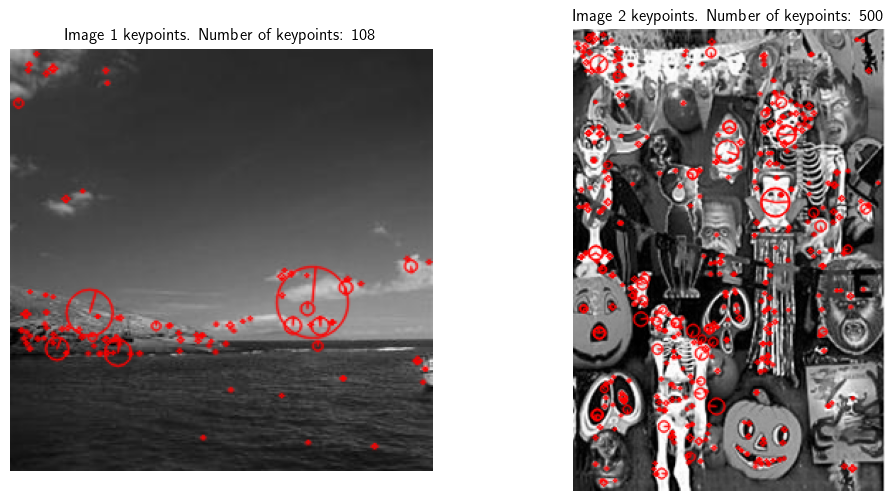

In [6]:
# Two sample images
image1 = train_images[150]
image2 = train_images[1100]

# Detect keypoints and compute descriptors for the two sample images
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Draw keypoints on the images
image_keypoints1 = cv2.drawKeypoints(
    image1, 
	keypoints1, 
	outImage = None,
	color = (255, 0, 0),
	flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
image_keypoints2 = cv2.drawKeypoints(
    image2,
	keypoints2,
	outImage = None,
	color = (255, 0, 0),
	flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_keypoints1)
ax[0].set_title(f"Image 1 keypoints. Number of keypoints: {len(keypoints1)}")
ax[0].axis("off")

ax[1].imshow(image_keypoints2)
ax[1].set_title(f"Image 2 keypoints. Number of keypoints: {len(keypoints2)}")
ax[1].axis("off")

plt.show()

However, by plotting the distribution of keypoints detected in the traning images we can see that the desired number of keypoints has been detected in most of the images.

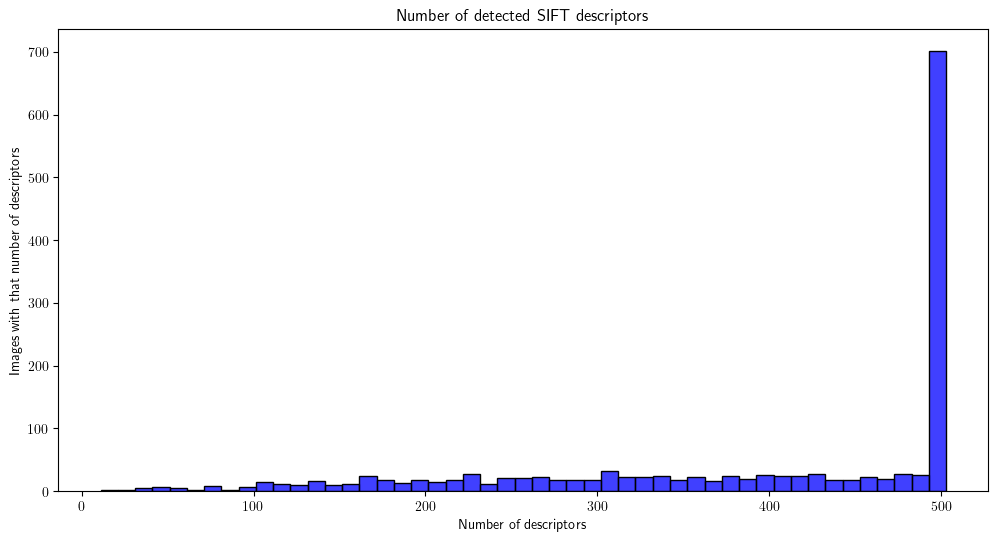

In [7]:
# # Histogram of descriptors
fig = plt.figure(figsize=(12, 6))
sns.histplot(n_descriptors, color="blue", binwidth=10)
plt.title("Number of detected SIFT descriptors")
plt.xlabel("Number of descriptors")
plt.ylabel("Images with that number of descriptors")
plt.show()

## K-Means Clustering

In the process of building a visual vocabulary we then perform K-Means clustering on the extracted features. 
Clustering is here performed on a random subset of the extracted features of fixed size for computational efficiency (*and since, after a series of tests, the final results don't seem to change significantly*).
The number of clusters is a hyperparameter that needs to be tuned, but a prior analysis of the silhouette score for different values of $k$ as odne below might give a hint on the good choice.

Computing silhouette scores:   0%|          | 0/19 [00:00<?, ?it/s]

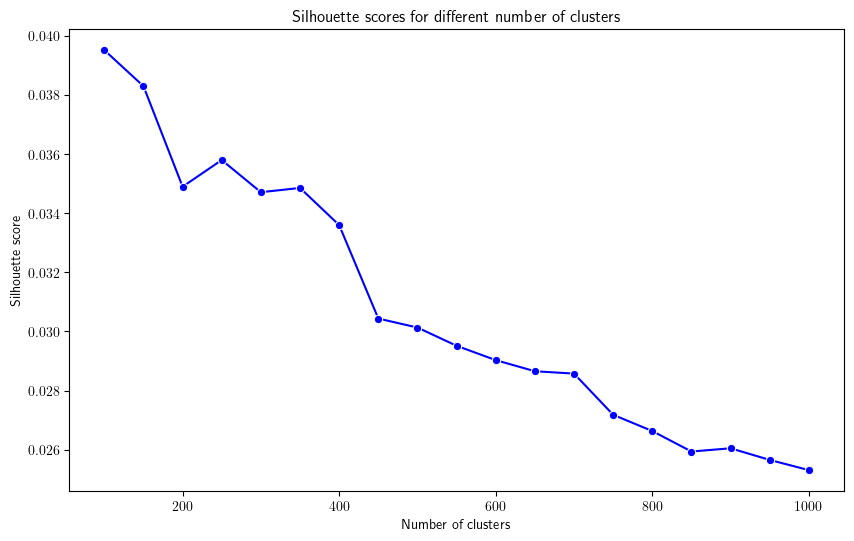

In [9]:
# Silhouette analysis

# Possible number of clusters
k_values = np.arange(100, 1001, 50)

# Random subset of descriptors
np.random.seed(3)
n_samples = 10000
sample_indices = np.random.choice(len(descriptors), n_samples, replace=False)
sample_descriptors = descriptors[sample_indices]

# Compute the silhouette scores
silhouette_scores = []
for k in tqdm.tqdm(k_values, desc="Computing silhouette scores", leave=False):
	kmeans = KMeans(n_clusters=k, random_state=42)
	cluster_labels = kmeans.fit_predict(sample_descriptors)
	silhouette_scores.append(silhouette_score(sample_descriptors, cluster_labels))

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_values, y=silhouette_scores, marker="o", color="blue")
plt.title("Silhouette scores for different number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show() 

The result of the previous analysis depends, of course, on the specific subset of descriptors chosen during each run of the clustering algorithm. However, after some tests, one can conclude that, as expected, the silhouette score decreases with the increase of the number of clusters $k$. The choice of the number of clusters is then a trade-off between the quality of the clustering and the computational efficiency / the size of the visual vocabulary. For this reason, by looking at the plot we can decide to fix $k=400$ since the decrease in the silhouette score is significant after this value (*alternatively $k \approx 250$ also seems to be a good choice*).

Cluster centers shape: (400, 128)


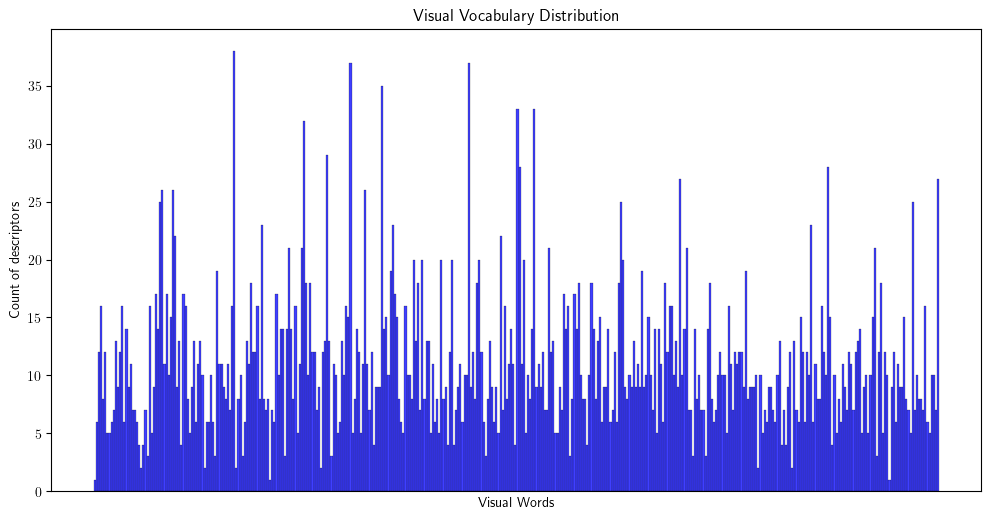

In [10]:
# Number of clusters
k = 400

# Clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(sample_descriptors)
centroids = kmeans.cluster_centers_

print(f"Cluster centers shape: {centroids.shape}")

# Visual words distribution
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(cluster_labels, bins=k, color="blue", ax=ax, binrange=(0, k), binwidth=1)
ax.set_xticks([i+0.5 for i in range(k)])
ax.set_xticklabels([str(i) for i in range(k)], rotation=90)
ax.set_title('Visual Vocabulary Distribution')
ax.set_xlabel('Visual Words')
ax.set_ylabel('Count of descriptors')
ax.set_xticks([])
plt.show()

## Normalized Histograms Representation

Once the visual vocabulary has been built, the centroids of each cluster will represent the visual words of the vocabulary.
The next step is to represent each image as normalized histograms of visual words.\
Using the `get_histogram()` function in the `utils.py` file we can indeed represent each image in the train and test sets as a normalized histogram having $k$ bins, each corresponding to the frequency of the corresponding visual word in the image. The function basically looks at the detected descriptors in the images, assigns them to the closest centroid and then builds the histogram by counting the occurrences of each predicted visual word.

In [11]:
# Compute histograms representations for train and test images
train_histograms = []
test_histograms = []

# Compute histograms for all training and test images
for image in tqdm.tqdm(
    train_images, 
    desc="Computing histograms for training images", 
    leave=False
):
    train_histograms.append(get_histogram(image, sift, kmeans, k))
train_histograms = np.array(train_histograms)
 
for image in tqdm.tqdm(
    test_images, 
    desc="Computing histograms for test images", 
    leave=False
):
    test_histograms.append(get_histogram(image, sift, kmeans, k))
test_histograms = np.array(test_histograms)

Computing histograms for training images:   0%|          | 0/1500 [00:00<?, ?it/s]

Computing histograms for test images:   0%|          | 0/2985 [00:00<?, ?it/s]

After having computed the histogram representation for each image, we can plot for each possible class the corresponding histogram for a sample training image and a sample test image of that clas to visually check if any similarity can be observed.

Train indexes:   0%|          | 0/15 [00:00<?, ?it/s]

Test indexes:   0%|          | 0/15 [00:00<?, ?it/s]

Computing chi-square distances and intersections:   0%|          | 0/15 [00:00<?, ?it/s]

Plotting histograms: 0it [00:00, ?it/s]

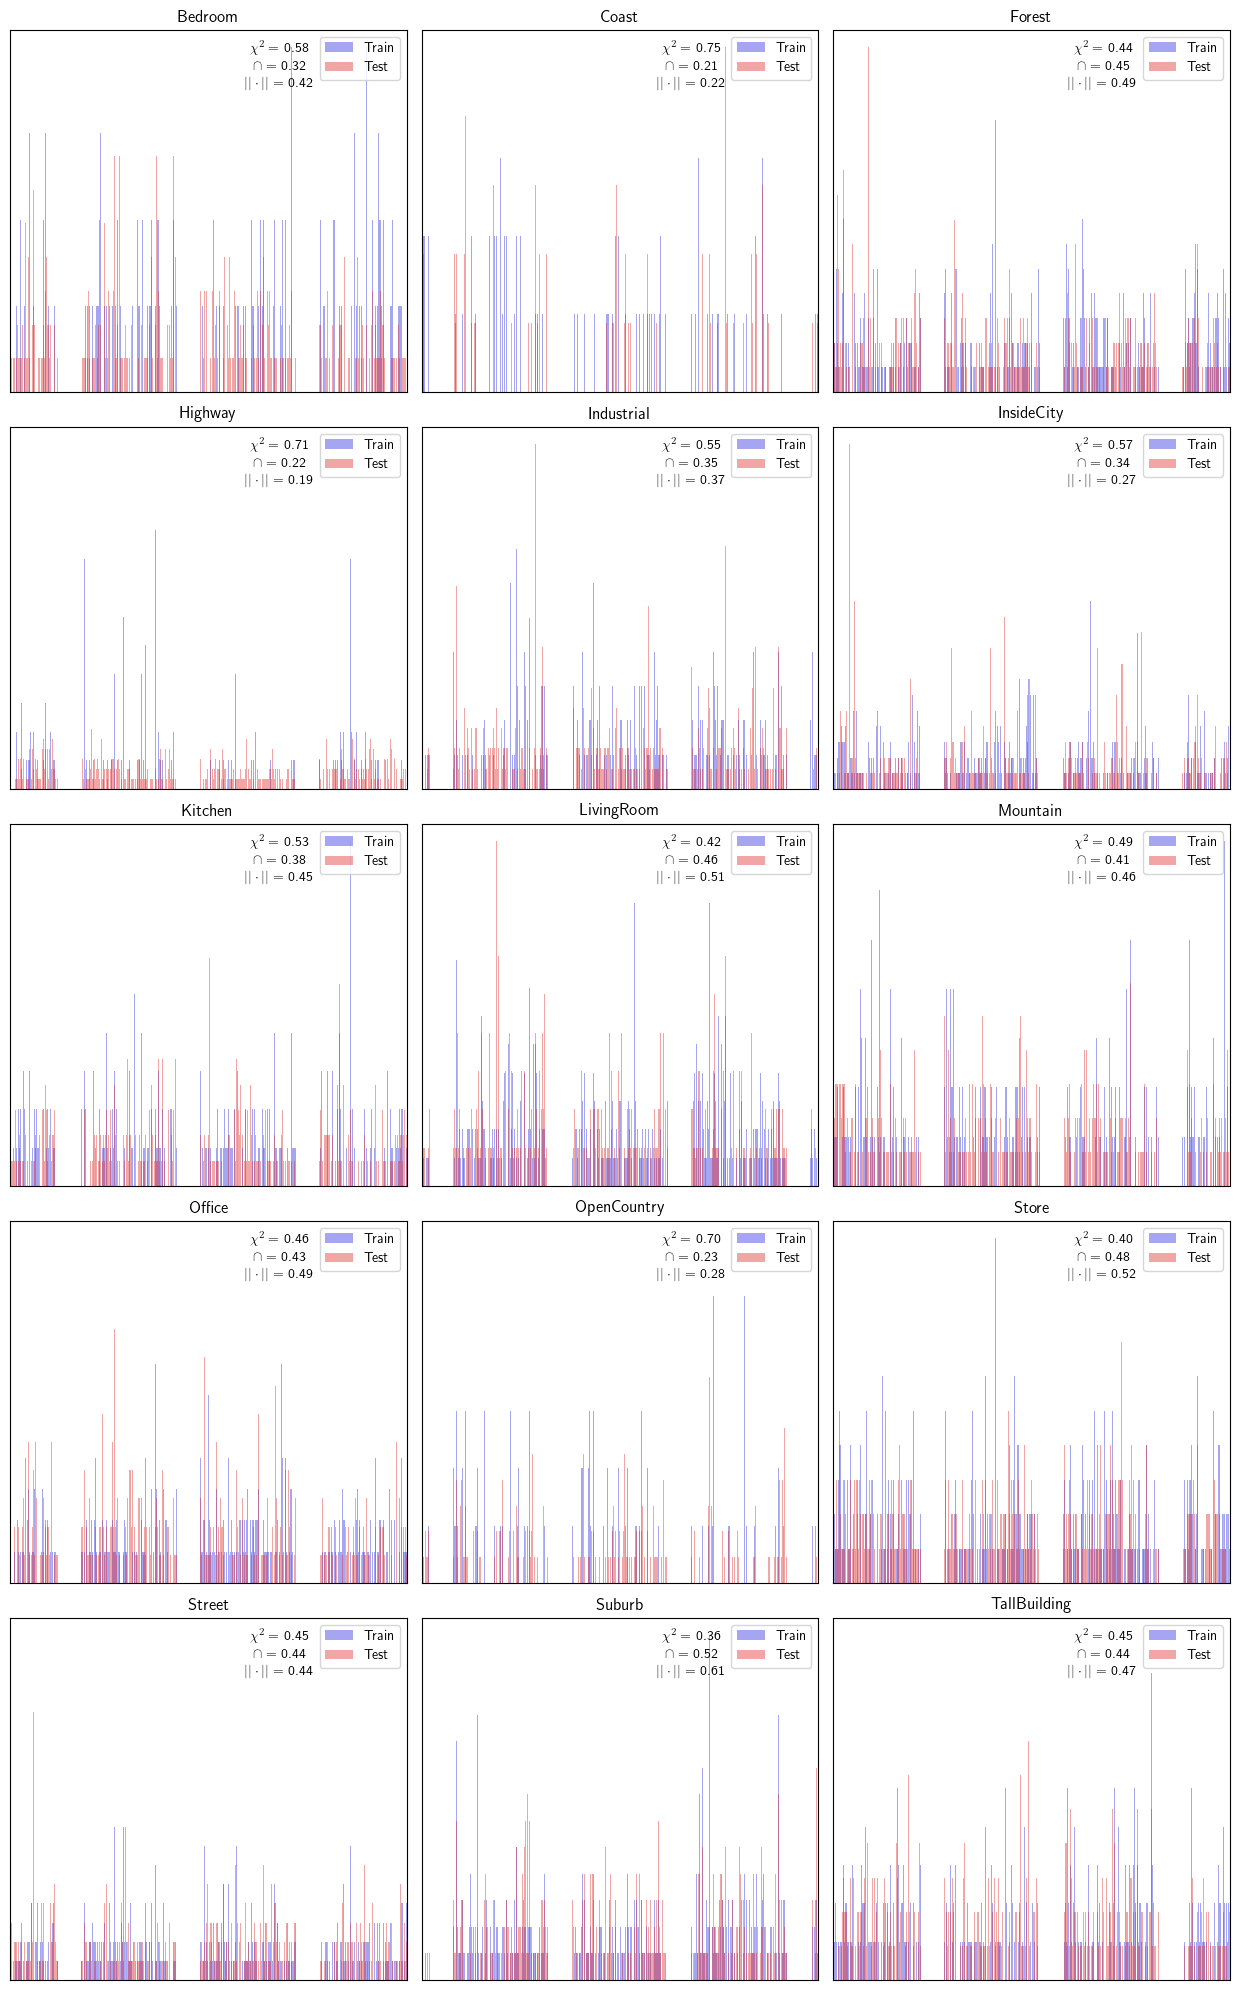

In [12]:
# Pick a pair of train/test images for each possible class
train_indexes = {class_name: [] for class_name in classes}
test_indexes = {class_name: [] for class_name in classes}

for label in tqdm.tqdm(set(train_labels), desc="Train indexes", leave=False):
	for i, _ in enumerate(train_labels):
		if train_labels[i] == label:
			train_indexes[classes[label]].append(i)
			break

for label in tqdm.tqdm(set(test_labels), desc="Test indexes", leave=False):
	for i, _ in enumerate(test_labels):
		if test_labels[i] == label:
			test_indexes[classes[label]].append(i)
			break

# Collect relative histograms
h_train = []
h_test = []
for class_name in tqdm.tqdm(classes, desc="Collecting histograms", leave=False):
	i_train = train_indexes[class_name][0]
	i_test = test_indexes[class_name][0]
	h_train.append(train_histograms[i_train])
	h_test.append(test_histograms[i_test])

# Compute chi-square distances, intersection and cosine similarity
def intersection(h1, h2):
	return np.sum(np.minimum(h1, h2))

def chi2_distance(h1, h2):
	return 0.5*np.sum((h1 - h2)**2 / (h1 + h2 + 1e-6))

def cosine_similarity(h1, h2):
	return np.dot(h1, h2) / (np.linalg.norm(h1) * np.linalg.norm(h2))

chi2_distances = np.zeros((len(classes), len(classes)))
intersections = np.zeros((len(classes), len(classes)))
similarities = np.zeros((len(classes), len(classes)))
for i in tqdm.tqdm(range(len(classes)), desc="Computing chi-square distances and intersections", leave=False):
	for j in range(len(classes)):
		chi2_distances[i, j] = chi2_distance(h_train[i], h_test[j])
		intersections[i, j] = intersection(h_train[i], h_test[j])
		similarities[i, j] = cosine_similarity(h_train[i], h_test[j])

# Plot
fig, ax = plt.subplots(5, 3, figsize=(12.5, 20))
ax = ax.flatten()

# Each subplot is one class (train and test histograms with transparency)
for i, class_name in tqdm.tqdm(enumerate(classes), desc="Plotting histograms", leave=False):
	sns.barplot(x=np.arange(k), y=h_train[i], ax=ax[i], color="blue", alpha=0.4, label="Train")
	sns.barplot(x=np.arange(k), y=h_test[i], ax=ax[i], color="red", alpha=0.4, label="Test")
	ax[i].set_title(f"{class_name}")
	ax[i].set_xticks([])
	ax[i].set_yticks([])
	ax[i].legend(loc='upper right')
	ax[i].text(0.68, 0.95, r"$\chi^2 =$ " f"{chi2_distances[i, i]:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
	ax[i].text(0.68, 0.90, r"$\cap =$ " f"{intersections[i, i]:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
	ax[i].text(0.68, 0.85, r"$||\cdot|| =$ " f"{similarities[i, i]:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
				 
plt.tight_layout()
plt.show()  

## TF-IDF Representation

As an alternative to the normalized histograms representation, we can also represent each image in the training and testing sets using the term frequency-inverse document frequency (TF-IDF) representation. This representation is obtained by weighting the normalized histograms with the inverse document frequency of each visual word, accounting in this way for the importance of each visual word in the whole dataset.The `get_tfidf()` function in the `utils.py` file can be used to compute the TF-IDF representation of the images.

In [13]:
# Compute TD-IDF representations for train and test images
train_tfidf = get_tfidf(train_images, sift, kmeans, k)
test_tfidf = get_tfidf(test_images, sift, kmeans, k)

Computing TF-IDF:   0%|          | 0/1500 [00:00<?, ?it/s]

Computing TF-IDF:   0%|          | 0/2985 [00:00<?, ?it/s]

And just as it has been done for the normalized histograms, we can plot for each possible class the corresponding TF-IDF representation for a sample training image and a sample test image of that class.

Train indexes:   0%|          | 0/15 [00:00<?, ?it/s]

Test indexes:   0%|          | 0/15 [00:00<?, ?it/s]

Plotting tf-idf: 0it [00:00, ?it/s]

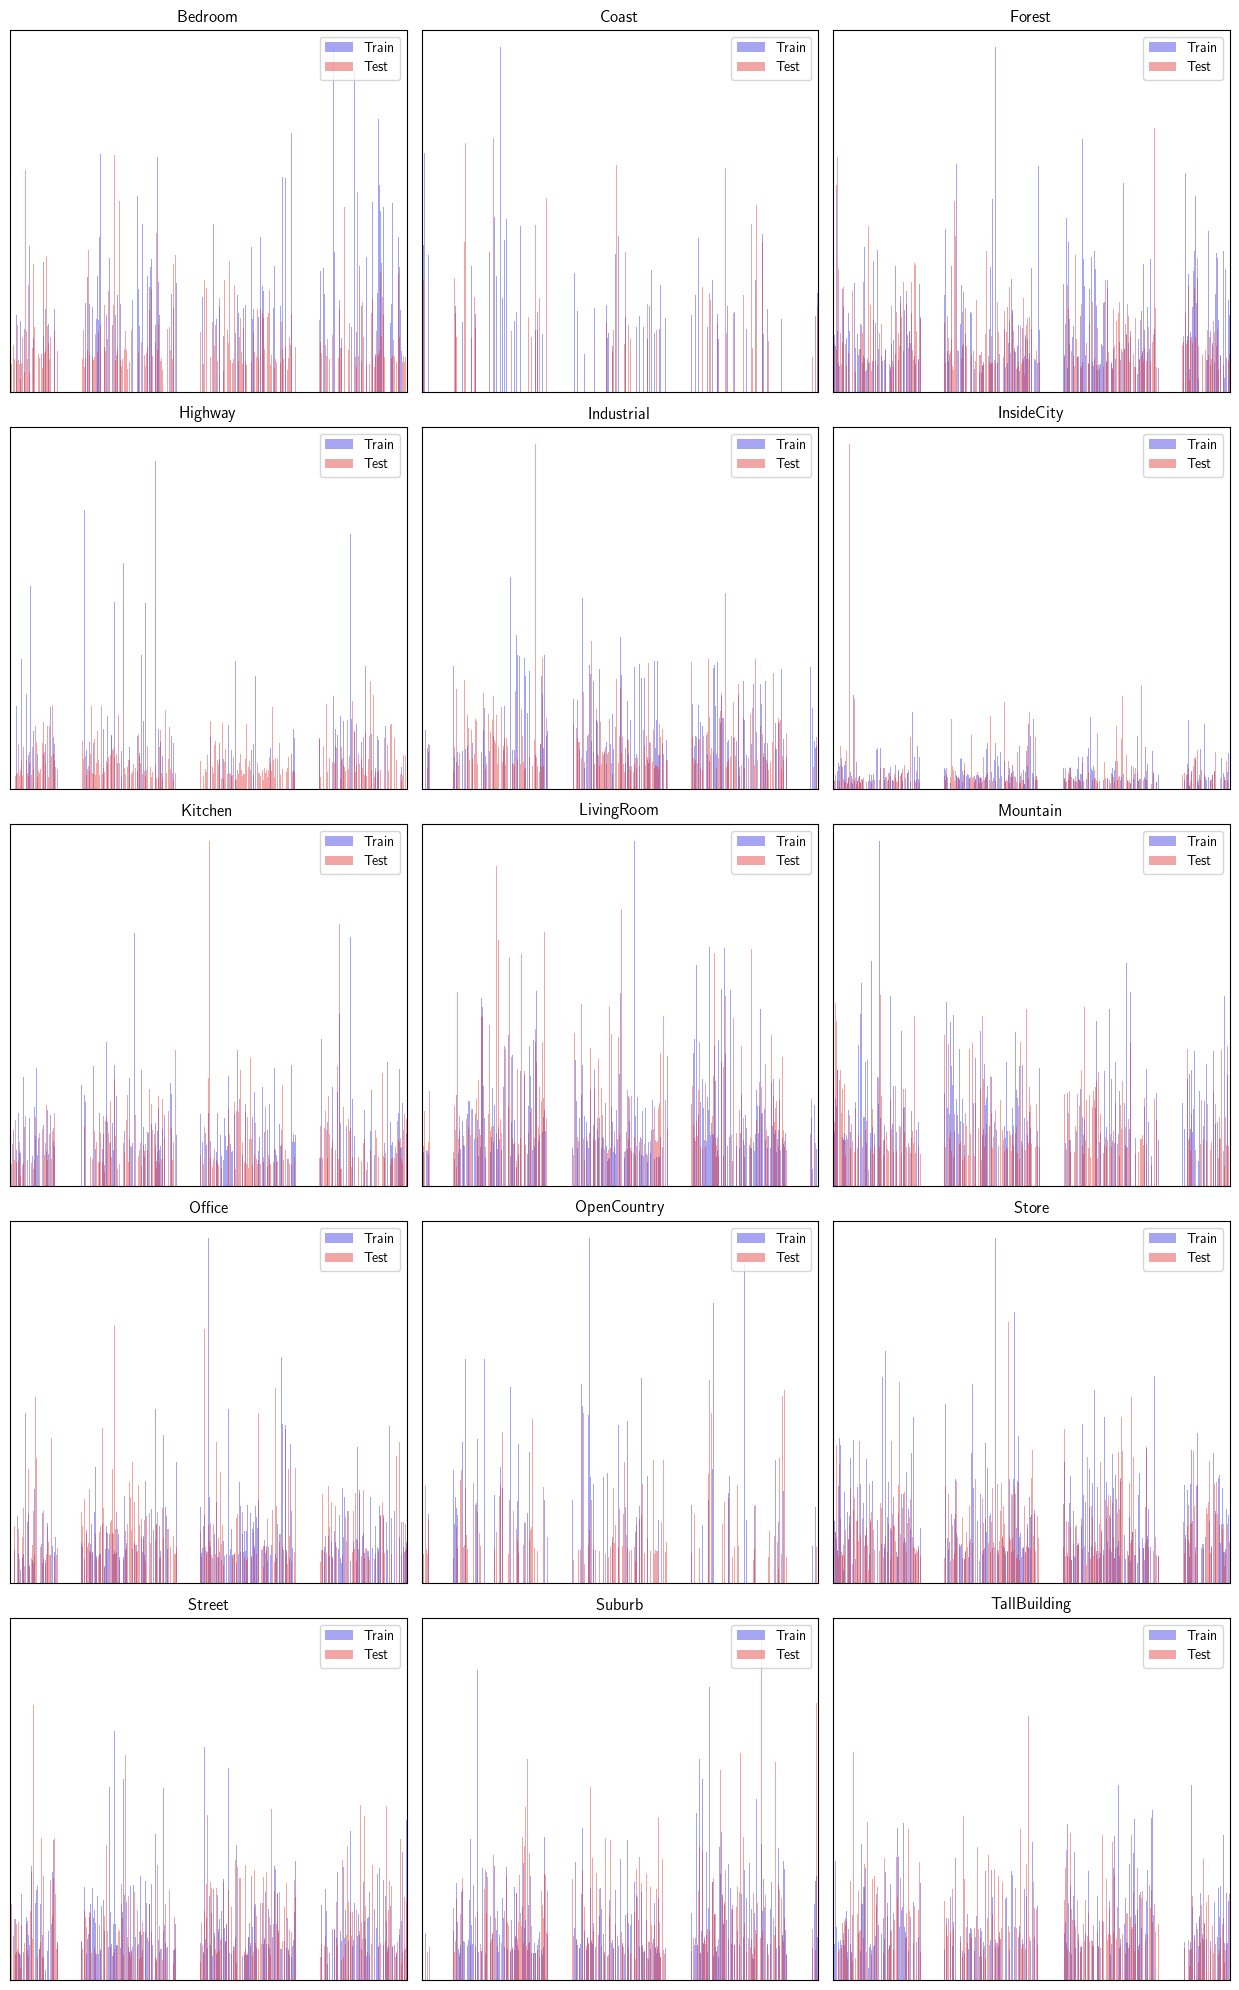

In [14]:
# Pick a pair of train/test images for each possible class
train_indexes = {class_name: [] for class_name in classes}
test_indexes = {class_name: [] for class_name in classes}

for label in tqdm.tqdm(set(train_labels), desc="Train indexes", leave=False):
	for i, _ in enumerate(train_labels):
		if train_labels[i] == label:
			train_indexes[classes[label]].append(i)
			break

for label in tqdm.tqdm(set(test_labels), desc="Test indexes", leave=False):
	for i, _ in enumerate(test_labels):
		if test_labels[i] == label:
			test_indexes[classes[label]].append(i)
			break

# Collect relative tf-idf
t_train = []
t_test = []
for class_name in tqdm.tqdm(classes, desc="Collecting histograms", leave=False):
	i_train = train_indexes[class_name][0]
	i_test = test_indexes[class_name][0]
	t_train.append(train_tfidf[i_train])
	t_test.append(test_tfidf[i_test])

# Plot
fig, ax = plt.subplots(5, 3, figsize=(12.5, 20))
ax = ax.flatten()

# Each subplot is one class (train and test histograms with transparency)
for i, class_name in tqdm.tqdm(enumerate(classes), desc="Plotting tf-idf", leave=False):
	sns.barplot(x=np.arange(k), y=t_train[i], ax=ax[i], color="blue", alpha=0.4, label="Train")
	sns.barplot(x=np.arange(k), y=t_test[i], ax=ax[i], color="red", alpha=0.4, label="Test")
	ax[i].set_title(f"{class_name}")
	ax[i].set_xticks([])
	ax[i].set_yticks([])
	ax[i].legend(loc='upper right')
				 
plt.tight_layout()
plt.show()  

## Dummy classifier

As a baseline for comparison with the later implemented model we can first evaluate the performance of the dummy classifier, which predicts the most frequent class in the test set for each image.

Dummy classifier accuracy: 10.39%


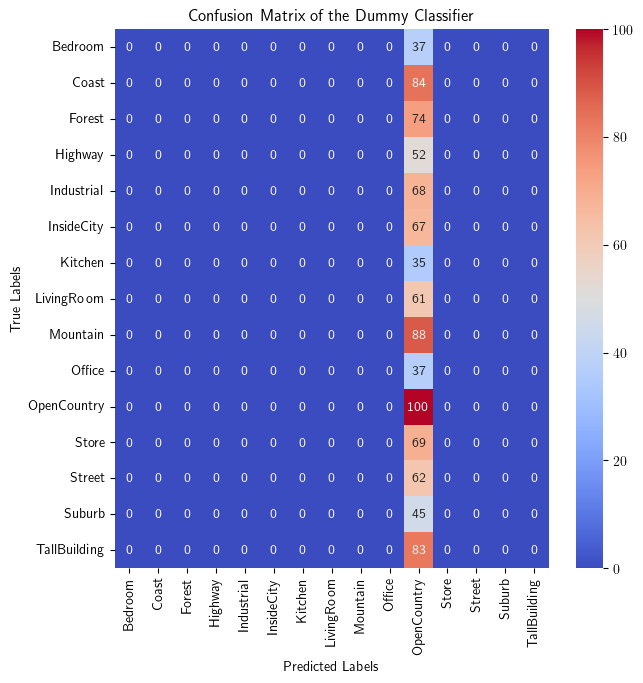

In [15]:
# Dummy classifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(test_histograms, test_labels)
test_predictions = dummy.predict(test_histograms)
dummy_score = dummy.score(test_histograms, test_labels)
print(f"Dummy classifier accuracy: {dummy_score * 100:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

# Plot
plt.figure(figsize=(7, 7))
sns.heatmap(
	conf_matrix * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of the Dummy Classifier')
plt.show()

The accuracy of the dummy classifier is $\sim 10 \%$.

## K-Nearest Neighbors Classifier

The first classifier we can try with the obtained visual vocabulary and the normalized histogram representation is the K-Nearest Neighbors (KNN) classifier.\
This kind of classifier simply looks at the normalized histogram representation of the test images and finds the $k$ training images that are most similar to the test image. The class of the test image is then assigned as the most common class among the $k$ nearest neighbors.\
We could use a single-nearest neighbor classifier, but with little effort it's possible to find a pseudo-optimal value for $k$ by looking at the accuracy on a subset of possible $k$ values.

Testing k-NN values:   0%|          | 0/50 [00:00<?, ?it/s]

Best k: 13


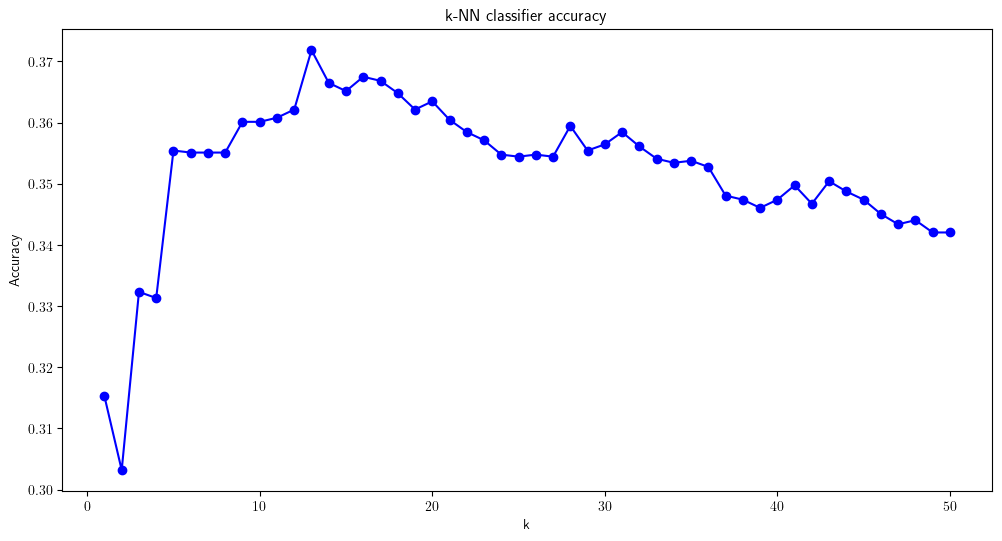

In [16]:
# Employ and asses a nearest neighbor classifier

# Test different values of k neighbors
k_values = range(1, 51)
accuracies = []
for k_ in tqdm.tqdm(k_values, desc="Testing k-NN values", leave=False):

	# Train k-NN classifier
	knn = KNeighborsClassifier(n_neighbors=k_)
	knn.fit(train_histograms, train_labels)

	# Predict labels for test set
	test_predictions = knn.predict(test_histograms)

	# Calculate accuracy
	accuracy = accuracy_score(test_labels, test_predictions)
	accuracies.append(accuracy)

# Best k
best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")

# Plot the accuracy for different values of k
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, marker='o', color='blue')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k-NN classifier accuracy')
plt.show()


We then select the best $k$ value found above and compute the confusion matrix for this classifier on the testing set.

Best k: 13
Accuracy: 37.19%


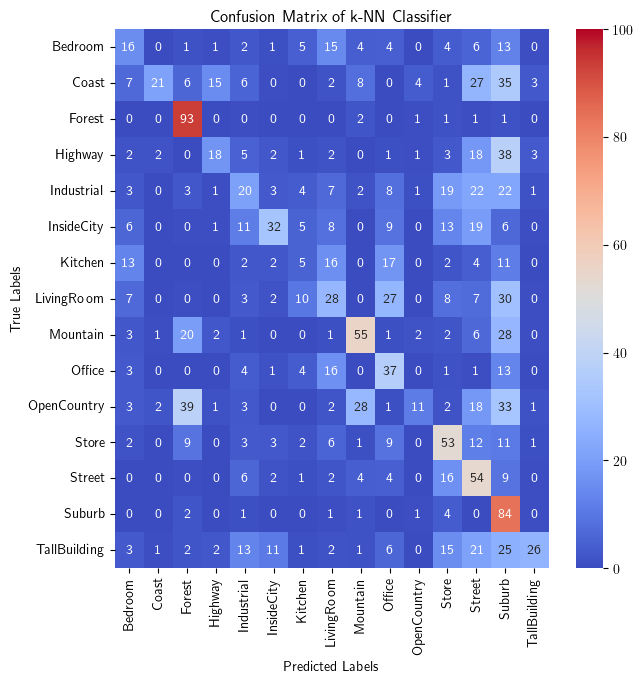

In [17]:
# Best k
best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")

# Test k-NN classifier with best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(train_histograms, train_labels)
test_predictions = knn.predict(test_histograms)
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy: {accuracy*100:.2f}%")

# k-NN classifier confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

# Plot
plt.figure(figsize=(7, 7))
sns.heatmap(
	conf_matrix * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of k-NN Classifier')
plt.show()

With this classifier we reach an average accuracy of $37.19\%$ on the testing set, which is at least an improvement with respect to the dummy classifier.

## Support Vector Machine (SVM) Classifiers

We can now try to achieve better results employing Support Vector Machine (SVM) classifiers with different inputs and kernels.\
All the implemented classifiers in this prject follow however the *one-vs-all* strategy, that is we first train $15$ different SVM classifiers, one for each class, using either the normalized histogram or the TF-IDF representation as input features and correctly modified ground truth labels. Then in the prediction phase, we assign to the test image the class corresponding to the SVM classifier that outputs the highest confidence score.\
The SVM classifiers here implemented differ for the kernel used and the input features, as follows:

1. SVM with **radial basis function (RBF) kernel** and:
	- **normalized histograms representation** as input features
	- **TF-IDF representation** as input features
  
2. SVM with $\chi^2$ **kernel** and:
	- **normalized histograms representation** as input features
	- **TF-IDF representation** as input features

#### 1. Radial Basis Function (RBF) Kernel

Train SVM classifiers with RBF kernel using the normalized histograms representation as input features and evaluate the accuracy on the testing set.

Training SVMs:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy with normalized histograms: 50.65%


Training SVMs:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy with TF-IDF histograms: 50.85%


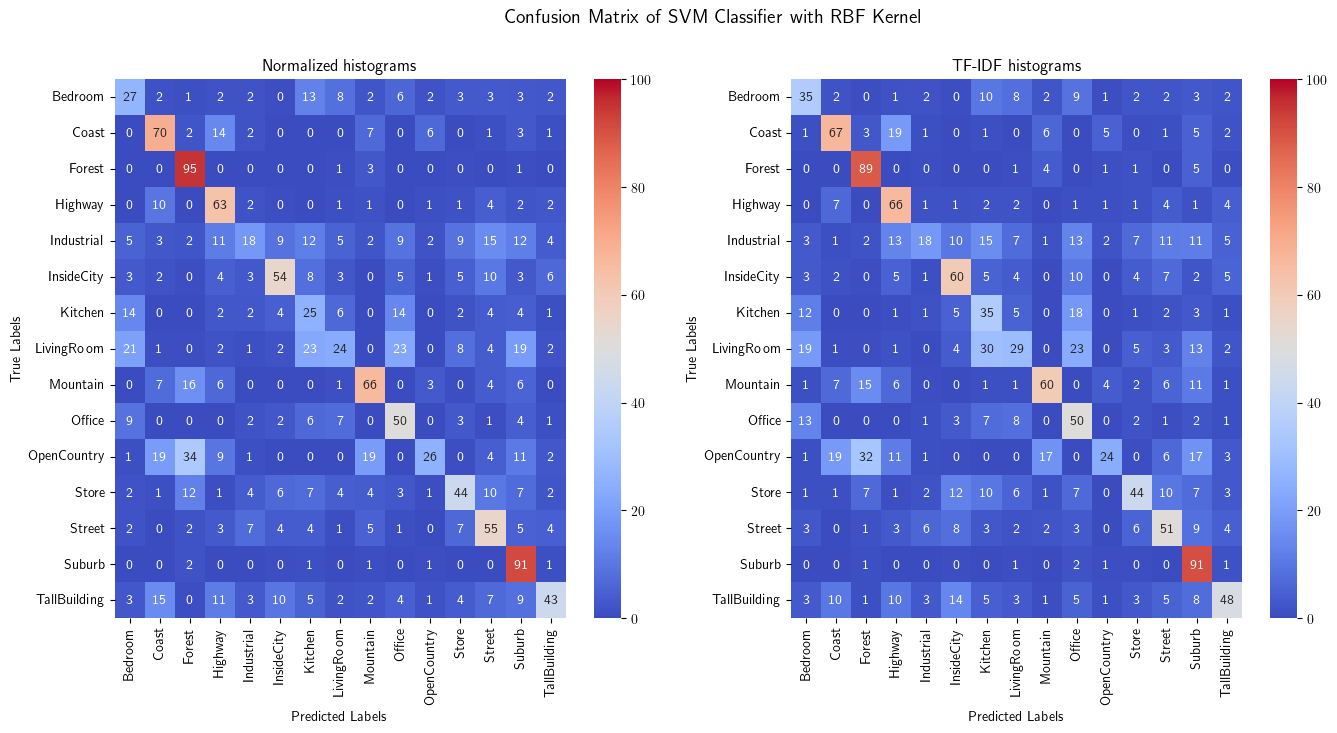

In [19]:
# One-vs-all SVM classifiers with radial basis function kernel (RBF)

# Using normalized histograms as inputs
SVMs = []
for target_label in tqdm.tqdm(set(train_labels), desc="Training SVMs", leave=False):
	
	# Change labels to {1, -1}
	one_vs_all_labels = [1 if label == target_label else -1 for label in train_labels]
	
	# Train and save SVM
	svm = SVC(probability=True, C=1.0, kernel='rbf')
	svm.fit(train_histograms, one_vs_all_labels)
	SVMs.append(svm)

# Predict for all test cases
predictions = np.array([svm.decision_function(test_histograms) for svm in SVMs])
test_predictions = np.argmax(predictions, axis=0)

# Average accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy with normalized histograms: {accuracy*100:.2f}%")
 
# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
conf_matrix_hist = conf_matrix / np.sum(conf_matrix, axis=1)


# Using TF-IDF histograms as inputs
SVMs = []
for target_label in tqdm.tqdm(set(train_labels), desc="Training SVMs", leave=False):
	
	# Change labels to {1, -1}
	one_vs_all_labels = [1 if label == target_label else -1 for label in train_labels]
	
	# Train and save SVM
	svm = SVC(probability=True, C=1.0, kernel='rbf')
	svm.fit(train_tfidf, one_vs_all_labels)
	SVMs.append(svm)
 
# Predict for all test cases
predictions = np.array([svm.decision_function(test_tfidf) for svm in SVMs])
test_predictions = np.argmax(predictions, axis=0)

# Average accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy with TF-IDF histograms: {accuracy*100:.2f}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
conf_matrix_tfidf = conf_matrix / np.sum(conf_matrix, axis=1)


# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Confusion Matrix of SVM Classifier with RBF Kernel', fontsize=14)

sns.heatmap(
	conf_matrix_hist * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes,
	ax=ax[0]
)
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')
ax[0].set_title('Normalized histograms')

sns.heatmap(
	conf_matrix_tfidf * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes,
	ax=ax[1]
)
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')
ax[1].set_title('TF-IDF histograms')

plt.show()

The obtained results are better than the simple KNN classifier, with average acuracies of $50.65\%$ using the normalized histograms and $50.85\%$ using the TF-IDF representation. From the confusion matrices, there are slight differences in the performance due to the type of input features used, but they are ot significant. Hence, in the following we will keep using the normalized histograms representation as input features.

#### 2. $\chi^2$ Kernel

We can also test if a better result can be achieved by using a different kernel for the SVM classifiers. In particular, we can use the $\chi^2$ kernel, which is known to work well with histograms. For this purpose, we only use the normalized histograms representation as input features in this case but the same can be done with the TF-IDF representation.\
One way to do so with te `sklearn` library is to pre-compute the Gram matrix using the `chi2_kernel()` function both for the training and testing sets and then use the `SVC` class with the `precomputed` kernel.

In [20]:
# Precompute Gram matrix for training and testing
train_gram = chi2_kernel(train_histograms, train_histograms, gamma=0.5)
test_gram = chi2_kernel(test_histograms, train_histograms, gamma=0.5)

Training SVMs:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy with chi^2 kernel: 51.46%


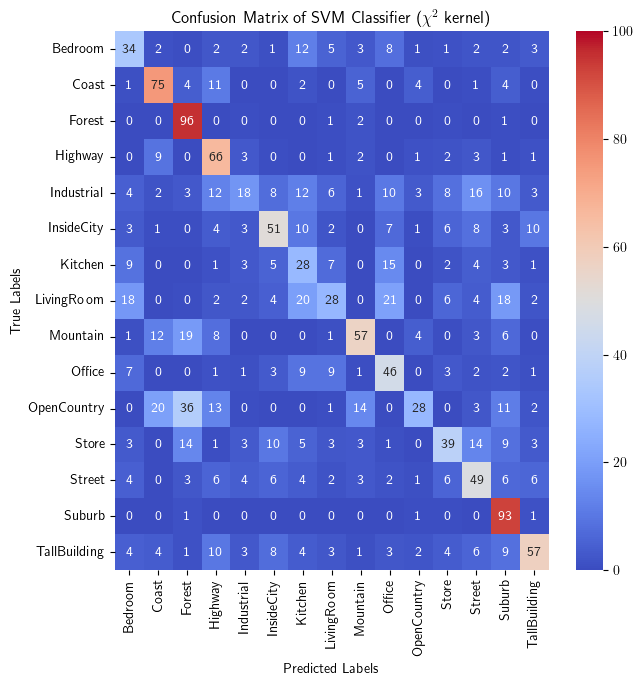

In [22]:
# One-vs-all SVM classifiers
SVMs = []
for target_label in tqdm.tqdm(set(train_labels), desc="Training SVMs", leave=False):
	
	# Change labels to {1, -1}
	one_vs_all_labels = [1 if label == target_label else -1 for label in train_labels]
	
	# Train and save SVM
	svm = SVC(probability=True, C=1.0, kernel='precomputed')
	svm.fit(train_gram, one_vs_all_labels)
	SVMs.append(svm)

# Predict for all test cases
predictions = np.array([svm.decision_function(test_gram) for svm in SVMs])
test_predictions = np.argmax(predictions, axis=0)

# Average accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy with chi^2 kernel: {accuracy*100:.2f}%")
 
# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
sns.heatmap(
	conf_matrix * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of SVM Classifier ' r'($\chi^2$ kernel)')
plt.show()

The change of the kernel seems to have marginally improved the accuracy of the classifier, at least for some classes. The average accuracy is now $51.46\%$.

## Grid Descriptors Sampling

We can now repeat the step performed above from the construction of the visual vocabulary to the implementation of the *one-vs-all* SVM classifiers but this time changing the way features are extracted from the images. In this case, we will sample SIFT descriptors on a regular grid over the images, with a spacing of $8$ pixels as suggested in the paper by *Lazebnik et al.*.\
Therefore, in this case keypoints are not detected by the SIFT detector but are taken in a regular (dense) grid. All the other steps from the vocabulary building to the SVM classifier remain the same.

In [23]:
# Compute descriptors from dense grid of keypoints
descriptors = []
n_descriptors = []
spacing = 8 # pixels
for image in tqdm.tqdm(
    train_images, 
    desc="Computing descriptors from grid of keypoints", 
    leave=False
):
	height, width = image.shape[:2]
	keypoints = [
    	cv2.KeyPoint(x, y, spacing) 
     	for y in range(spacing, height, spacing) 
      	for x in range(spacing, width, spacing)
    ]
	_, image_descriptors = sift.compute(image, keypoints)
	n_descriptors.append(len(image_descriptors))
	descriptors.extend(image_descriptors)
	
descriptors = np.array(descriptors)	

print(f"Number of grid SIFT descriptors: {len(descriptors)}")


Computing descriptors from grid of keypoints:   0%|          | 0/1500 [00:00<?, ?it/s]

Number of grid SIFT descriptors: 1482434


Also in this case the number of keypoints per image can vary but this time due to the different aspect ratios of the images and their sizes as in the example below. However, the difference in this approach is that keypoints are sampled uniformly in the images, which means that uniform intensity regions will also be captured by the SIFT descriptors. Intuitivelly this might help discriminating between different classes of images for instance by capturing the presence of a sky or a road in the image as explained by *Lazebnik et al.*.

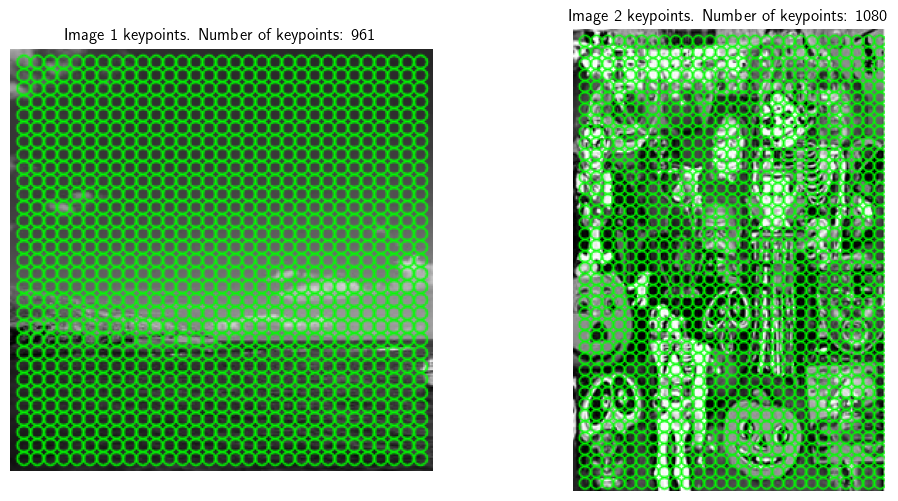

In [24]:
# Two sample images
image1 = train_images[100]
image2 = train_images[1100]

height1, width1 = image1.shape[:2]
height2, width2 = image2.shape[:2]

keypoints1 = [
    cv2.KeyPoint(x, y, spacing) 
	for y in range(spacing, height1, spacing) 
	for x in range(spacing, width1, spacing)
]
keypoints2 = [
    cv2.KeyPoint(x, y, spacing) 
	for y in range(spacing, height2, spacing) 
	for x in range(spacing, width2, spacing)
]


# Compute descriptors for the two sample images
_, descriptors1 = sift.compute(image1, keypoints1)
_, descriptors2 = sift.compute(image2, keypoints2)

# Draw keypoints on the images
image_keypoints1 = cv2.drawKeypoints(
    image1, 
	keypoints1, 
	outImage = None,
	color = (0, 255, 0),
	flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
image_keypoints2 = cv2.drawKeypoints(
    image2,
	keypoints2,
	outImage = None,
	color = (0, 255, 0),
	flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_keypoints1)
ax[0].set_title(f"Image 1 keypoints. Number of keypoints: {len(keypoints1)}")
ax[0].axis("off")

ax[1].imshow(image_keypoints2)
ax[1].set_title(f"Image 2 keypoints. Number of keypoints: {len(keypoints2)}")
ax[1].axis("off")

plt.show()


As said, we then repeat all the necessary steps for the construction of the visual vocabulary and the implementation of the SVM classifiers with the new features.

Computing histograms for training images:   0%|          | 0/1500 [00:00<?, ?it/s]

Computing histograms for test images:   0%|          | 0/2985 [00:00<?, ?it/s]

Training SVMs:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy with chi^2 kernel and dense grid descriptors sampling: 48.61%


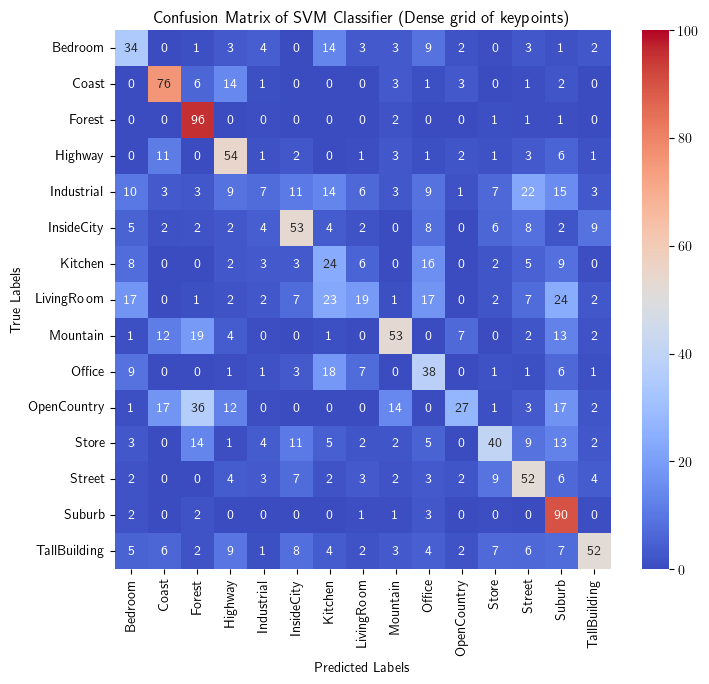

In [25]:
# Clustering
np.random.seed(3)
n_samples = 25000
sample_indices = np.random.choice(len(descriptors), n_samples, replace=False)
sample_descriptors = descriptors[sample_indices]
k = 400
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(sample_descriptors)

# Compute histograms representations for train and test images
train_histograms = []
test_histograms = []
for image in tqdm.tqdm(
    train_images, 
    desc="Computing histograms for training images", 
    leave=False
):
    train_histograms.append(get_histogram(image, sift, kmeans, k))
train_histograms = np.array(train_histograms)
for image in tqdm.tqdm(
    test_images, 
    desc="Computing histograms for test images", 
    leave=False
):
    test_histograms.append(get_histogram(image, sift, kmeans, k))
test_histograms = np.array(test_histograms)

# Precompute Gram matrix for training and testing
train_gram = chi2_kernel(train_histograms, train_histograms, gamma=0.5)
test_gram = chi2_kernel(test_histograms, train_histograms, gamma=0.5)

# One-vs-all SVM classifiers
SVMs = []
for target_label in tqdm.tqdm(set(train_labels), desc="Training SVMs", leave=False):
	
	# Change labels to {1, -1}
	one_vs_all_labels = [1 if label == target_label else -1 for label in train_labels]
	
	# Train and save SVM
	svm = SVC(probability=True, C=1.0, kernel='precomputed')
	svm.fit(train_gram, one_vs_all_labels)
	SVMs.append(svm)

# Predict for all test cases
predictions = np.array([svm.decision_function(test_gram) for svm in SVMs])
test_predictions = np.argmax(predictions, axis=0)

# Average accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy with chi^2 kernel and dense grid descriptors sampling: {accuracy*100:.2f}%")
 
# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(
	conf_matrix * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of SVM Classifier (Dense grid of keypoints)')
plt.show()

From the previous confusion matrix we can notice that the obtained results are comparable to the ones obtained with the SIFT detector, hence the choice of the feature extraction method does not seem to affect the final results significantly, at least for the parameters chosen in this experiment.

## Spatial Pyramid Matching

Finally, we can try to improve the performance of the classifier by adding spatial information to the Bag of Visual Words model. As explained by *Lazebnik et al.*, this can be done by dividing the image into a certain number of spatial regions (by building grids at different levels) and then computing the histograms of visual words for each region. The final representation of the image is then obtained by concatenating all the histograms of the idfferent regions.\
Moreover, a weight is assigned to the histograms from different resolution level, with higher weigths assigned to the histograms of finer grids and lower weights to the histograms of coarser grids.\
This is implemented in the `get_pyramid_histogram()` function in the `utils.py` file, which computes this extended histogram representation for each given image. 

In [26]:
# Set pyramid levels
LEVELS = range(0, 3)

# Compute histograms for all training and test images
train_histograms = []
test_histograms = []
for image in tqdm.tqdm(train_images, desc="Computing histograms for training images", leave=False):
	train_histograms.append(get_pyramid_histogram(image, LEVELS, sift, kmeans, k))
train_histograms = np.array(train_histograms)
 
for image in tqdm.tqdm(test_images, desc="Computing histograms for test images", leave=False):
	test_histograms.append(get_pyramid_histogram(image, LEVELS, sift, kmeans, k))
test_histograms = np.array(test_histograms)

Computing histograms for training images:   0%|          | 0/1500 [00:00<?, ?it/s]

Computing histograms for test images:   0%|          | 0/2985 [00:00<?, ?it/s]

Using this representation of the images we can then train a multi-class SVM classifier with the same *one-vs-all* strategy as before and evaluate the accuracy on the testing set. This time we need to use the pyramid matching kernel in order to correctly compare the extended histograms of the images. Such kernel has been implemented in the `pyramid_kernel()` function in the `utils.py` file. The approach is the same adopted before with the $\chi^2$ kernel: we first compute the necesary Gram matrices and then use the `SVC` class with the `precomputed` kernel.

In [27]:
# Precompute Gram matrix for training and testing
train_gram = pyramid_kernel(train_histograms, train_histograms)
test_gram = pyramid_kernel(test_histograms, train_histograms)

Computing kernel:   0%|          | 0/1500 [00:00<?, ?it/s]

Computing kernel:   0%|          | 0/2985 [00:00<?, ?it/s]

Training SVMs:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy with pyramid histograms: 75.24%


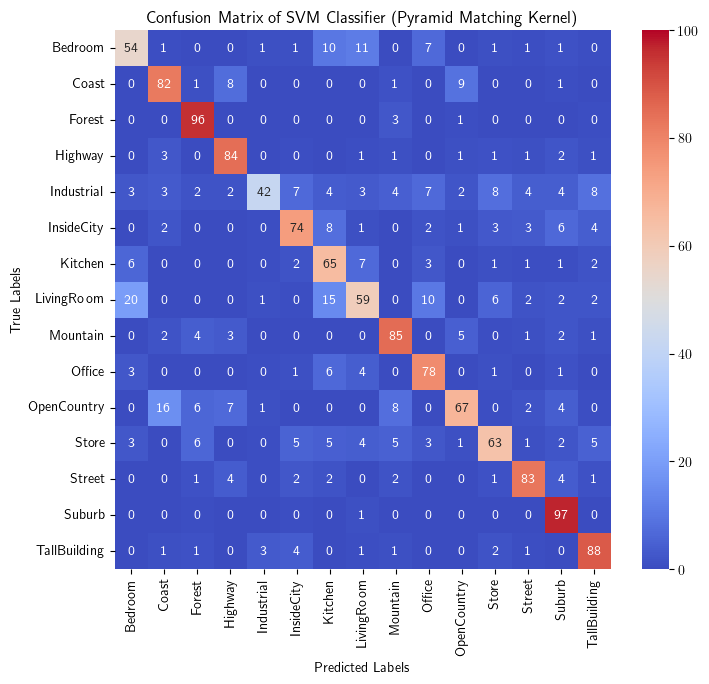

In [28]:
# One-vs-all SVM classifiers
SVMs = []
for target_label in tqdm.tqdm(set(train_labels), desc="Training SVMs", leave=False):
	
	# Change labels to {1, -1}
	one_vs_all_labels = [1 if label == target_label else -1 for label in train_labels]
	
	# Train and save SVM
	svm = SVC(probability=True, C=1.0, kernel='precomputed')
	svm.fit(train_gram, one_vs_all_labels)
	SVMs.append(svm)

# Predict for all test cases
predictions = np.array([svm.decision_function(test_gram) for svm in SVMs])
test_predictions = np.argmax(predictions, axis=0)

# Average accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy with pyramid histograms: {accuracy*100:.2f}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

# Plot confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(
	conf_matrix * 100,
	annot=True, 
	fmt='.0f', 
	vmin = 0,
	vmax = 100,
	cmap='coolwarm', 
	xticklabels=classes, 
	yticklabels=classes
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of SVM Classifier (Pyramid Matching Kernel)')
plt.show()

Although we didn't quite reach the results shown by *Lazebnik et al.* in their paper, we can clearly see that this approach outperforms the previous ones, with an average accuracy of $75.24\%$ on the testing set.